In [1]:
import numpy as np
import pandas as pd
import pandas.api.types
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import GroupKFold, StratifiedGroupKFold

import lightgbm as lgb

## 元の特徴量
| 英名 | 日本語名 | 詳細説明 |
| --- | --- | --- |
| age_approx | おおよその年齢 | 画像撮影時の患者のおおよその年齢 |
| clin_size_long_diam_mm | 最大径 (mm) | 病変の最大径 (mm) |
| tbp_lv_A | A 内部病変 | 病変内のAレベル |
| tbp_lv_Aext | A 外部病変 | 病変外のAレベル |
| tbp_lv_B | B 内部病変 | 病変内のBレベル |
| tbp_lv_Bext | B 外部病変 | 病変外のBレベル |
| tbp_lv_C | C 内部病変 | 病変内のCレベル |
| tbp_lv_Cext | C 外部病変 | 病変外のCレベル |
| tbp_lv_H | 色相 (内部) | 病変内の色相 |
| tbp_lv_Hext | 色相 (外部) | 病変外の色相 |
| tbp_lv_L | 明度 (内部) | 病変内の明度 |
| tbp_lv_Lext | 明度 (外部) | 病変外の明度 |
| tbp_lv_areaMM2 | 面積 (mm^2) | 病変の面積 (mm^2) |
| tbp_lv_area_perim_ratio | 周囲長対面積比 | 周囲長と面積の比率 |
| tbp_lv_color_std_mean | 色不規則性 | 病変内の色のばらつき |
| tbp_lv_deltaA | A コントラスト | 病変内外のAコントラスト |
| tbp_lv_deltaB | B コントラスト | 病変内外のBコントラスト |
| tbp_lv_deltaL | 明度コントラスト | 病変内外の明度コントラスト |
| tbp_lv_deltaLBnorm | コントラスト比 | 病変と周辺皮膚のコントラスト比 |
| tbp_lv_eccentricity | 偏心率 | 病変の偏心率 |
| tbp_lv_minorAxisMM | 最小径 (mm) | 病変の最小径 (mm) |
| tbp_lv_nevi_confidence | ネビス信頼度 | ネビスの信頼度スコア |
| tbp_lv_norm_border | 境界不規則性 | 境界の不規則性スコア |
| tbp_lv_norm_color | 色のばらつき | 色のばらつきスコア |
| tbp_lv_perimeterMM | 周囲長 (mm) | 病変の周囲長 (mm) |
| tbp_lv_radial_color_std_max | 色の非対称性 | 病変内の色の非対称性 |
| tbp_lv_stdL | 明度標準偏差 | 病変内の明度の標準偏差 |
| tbp_lv_stdLExt | 明度標準偏差 (外部) | 病変外の明度の標準偏差 |
| tbp_lv_symm_2axis | 対称性 | 病変の対称性スコア |
| tbp_lv_symm_2axis_angle | 対称軸角度 | 対称軸の角度 |
| tbp_lv_x | X座標 | 病変のX座標 |
| tbp_lv_y | Y座標 | 病変のY座標 |
| tbp_lv_z | Z座標 | 病変のZ座標 |


## 新しく作成した特徴量
| 英名 | 日本語名 | 詳細説明 |
| --- | --- | --- |
| lesion_size_ratio | 病変サイズ比 | 病変の最小径と最大径の比率 |
| lesion_shape_index | 病変形状指数 | 病変の面積と周囲長の平方の比率 |
| hue_contrast | 色相コントラスト | 病変内外の色相の差の絶対値 |
| luminance_contrast | 明度コントラスト | 病変内外の明度の差の絶対値 |
| lesion_color_difference | 色差 | 病変内外の色差の総和 |
| border_complexity | 境界複雑度 | 境界不規則性と対称性の総和 |
| color_uniformity | 色の均一性 | 色の標準偏差と放射状色の標準偏差の比率 |
| 3d_position_distance | 3D位置距離 | 病変の3D位置座標の距離 |
| perimeter_to_area_ratio | 周囲長対面積比 | 周囲長と面積の比率 |
| lesion_visibility_score | 病変可視性スコア | コントラスト比と色のばらつきの総和 |
| combined_anatomical_site | 結合解剖学的部位 | 一般的な解剖部位と位置の組み合わせ |
| symmetry_border_consistency | 対称性境界の一貫性 | 対称性スコアと境界不規則性の積 |
| color_consistency | 色の一貫性 | 明度の標準偏差と外部明度の比率 |
| size_age_interaction | サイズと年齢の相互作用 | 病変の最大径と年齢の積 |
| hue_color_std_interaction | 色相と色標準偏差の相互作用 | 色相と色の標準偏差の積 |
| lesion_severity_index | 病変重症度指数 | 境界不規則性、色のばらつき、偏心率の平均 |
| shape_complexity_index | 形状複雑度指数 | 境界複雑度と病変形状指数の総和 |
| color_contrast_index | 色コントラスト指数 | 色差とコントラスト比の総和 |
| log_lesion_area | 病変面積の対数 | 病変面積の対数値 |
| normalized_lesion_size | 正規化病変サイズ | 最大径と年齢の比率 |
| mean_hue_difference | 平均色相差 | 色相の平均差 |
| std_dev_contrast | 標準偏差コントラスト | 色差の標準偏差 |
| color_shape_composite_index | 色と形状の総合指数 | 色のばらつき、周囲長対面積比、対称性の平均 |
| 3d_lesion_orientation | 3D病変の向き | 3D座標の角度 |
| overall_color_difference | 総色差 | 色差の平均 |
| symmetry_perimeter_interaction | 対称性と周囲長の相互作用 | 対称性スコアと周囲長の積 |
| comprehensive_lesion_index | 総合病変指数 | 境界不規則性、偏心率、色のばらつき、対称性の平均 |


In [2]:
N_FOLDS = 5

In [3]:
base_path = "/home/toru/PycharmProjects/isic-2024-challenge"
df_train = pd.read_csv(f"{base_path}/train-metadata.csv")
df_test = pd.read_csv(f"{base_path}/test-metadata.csv")

def feature_engineering(df):
    df["lesion_size_ratio"] = df["tbp_lv_minorAxisMM"] / df["clin_size_long_diam_mm"]
    df["lesion_shape_index"] = df["tbp_lv_areaMM2"] / (df["tbp_lv_perimeterMM"] ** 2)
    df["hue_contrast"] = (df["tbp_lv_H"] - df["tbp_lv_Hext"]).abs()
    df["luminance_contrast"] = (df["tbp_lv_L"] - df["tbp_lv_Lext"]).abs()
    df["lesion_color_difference"] = np.sqrt(df["tbp_lv_deltaA"] ** 2 + df["tbp_lv_deltaB"] ** 2 + df["tbp_lv_deltaL"] ** 2)
    df["border_complexity"] = df["tbp_lv_norm_border"] + df["tbp_lv_symm_2axis"]
    df["color_uniformity"] = df["tbp_lv_color_std_mean"] / df["tbp_lv_radial_color_std_max"]
    df["3d_position_distance"] = np.sqrt(df["tbp_lv_x"] ** 2 + df["tbp_lv_y"] ** 2 + df["tbp_lv_z"] ** 2) 
    df["perimeter_to_area_ratio"] = df["tbp_lv_perimeterMM"] / df["tbp_lv_areaMM2"]
    df["lesion_visibility_score"] = df["tbp_lv_deltaLBnorm"] + df["tbp_lv_norm_color"]
    df["combined_anatomical_site"] = df["anatom_site_general"] + "_" + df["tbp_lv_location"]
    df["symmetry_border_consistency"] = df["tbp_lv_symm_2axis"] * df["tbp_lv_norm_border"]
    df["color_consistency"] = df["tbp_lv_stdL"] / df["tbp_lv_Lext"]
    
    df["size_age_interaction"] = df["clin_size_long_diam_mm"] * df["age_approx"]
    df["hue_color_std_interaction"] = df["tbp_lv_H"] * df["tbp_lv_color_std_mean"]
    df["lesion_severity_index"] = (df["tbp_lv_norm_border"] + df["tbp_lv_norm_color"] + df["tbp_lv_eccentricity"]) / 3
    df["shape_complexity_index"] = df["border_complexity"] + df["lesion_shape_index"]
    df["color_contrast_index"] = df["tbp_lv_deltaA"] + df["tbp_lv_deltaB"] + df["tbp_lv_deltaL"] + df["tbp_lv_deltaLBnorm"]
    df["log_lesion_area"] = np.log(df["tbp_lv_areaMM2"] + 1)
    df["normalized_lesion_size"] = df["clin_size_long_diam_mm"] / df["age_approx"]
    df["mean_hue_difference"] = (df["tbp_lv_H"] + df["tbp_lv_Hext"]) / 2
    df["std_dev_contrast"] = np.sqrt((df["tbp_lv_deltaA"] ** 2 + df["tbp_lv_deltaB"] ** 2 + df["tbp_lv_deltaL"] ** 2) / 3)
    df["color_shape_composite_index"] = (df["tbp_lv_color_std_mean"] + df["tbp_lv_area_perim_ratio"] + df["tbp_lv_symm_2axis"]) / 3
    df["3d_lesion_orientation"] = np.arctan2(df_train["tbp_lv_y"], df_train["tbp_lv_x"])
    df["overall_color_difference"] = (df["tbp_lv_deltaA"] + df["tbp_lv_deltaB"] + df["tbp_lv_deltaL"]) / 3
    df["symmetry_perimeter_interaction"] = df["tbp_lv_symm_2axis"] * df["tbp_lv_perimeterMM"]
    df["comprehensive_lesion_index"] = (df["tbp_lv_area_perim_ratio"] + df["tbp_lv_eccentricity"] + df["tbp_lv_norm_color"] + df["tbp_lv_symm_2axis"]) / 4

    new_num_cols = [
        "lesion_size_ratio", "lesion_shape_index", "hue_contrast",
        "luminance_contrast", "lesion_color_difference", "border_complexity",
        "color_uniformity", "3d_position_distance", "perimeter_to_area_ratio",
        "lesion_visibility_score", "symmetry_border_consistency", "color_consistency",

        "size_age_interaction", "hue_color_std_interaction", "lesion_severity_index", 
        "shape_complexity_index", "color_contrast_index", "log_lesion_area",
        "normalized_lesion_size", "mean_hue_difference", "std_dev_contrast",
        "color_shape_composite_index", "3d_lesion_orientation", "overall_color_difference",
        "symmetry_perimeter_interaction", "comprehensive_lesion_index",
    ]
    new_cat_cols = ["combined_anatomical_site"]
    return df, new_num_cols, new_cat_cols

df_train, new_num_cols, new_cat_cols = feature_engineering(df_train.copy())
df_test, _, _ = feature_engineering(df_test.copy())
    
num_cols = [
    'age_approx', 'clin_size_long_diam_mm', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext', 
    'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L', 
    'tbp_lv_Lext', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio', 'tbp_lv_color_std_mean', 
    'tbp_lv_deltaA', 'tbp_lv_deltaB', 'tbp_lv_deltaL', 'tbp_lv_deltaLB',
    'tbp_lv_deltaLBnorm', 'tbp_lv_eccentricity', 'tbp_lv_minorAxisMM',
    'tbp_lv_nevi_confidence', 'tbp_lv_norm_border', 'tbp_lv_norm_color',
    'tbp_lv_perimeterMM', 'tbp_lv_radial_color_std_max', 'tbp_lv_stdL',
    'tbp_lv_stdLExt', 'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle',
    'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z',
] + new_num_cols
# anatom_site_general
cat_cols = ["sex", "tbp_tile_type", "tbp_lv_location", "tbp_lv_location_simple"] + new_cat_cols
train_cols = num_cols + cat_cols

category_encoder = OrdinalEncoder(
    categories='auto',
    dtype=int,
    handle_unknown='use_encoded_value',
    unknown_value=-2,
    encoded_missing_value=-1,
)

X_cat = category_encoder.fit_transform(df_train[cat_cols])
for c, cat_col in enumerate(cat_cols):
    df_train[cat_col] = X_cat[:, c]

/tmp/ipykernel_353598/142241762.py:2: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv(f"{base_path}/train-metadata.csv")


In [4]:
gkf = GroupKFold(n_splits=N_FOLDS) # , shuffle=True, random_state=42

df_train["fold"] = -1
for idx, (train_idx, val_idx) in enumerate(gkf.split(df_train, df_train["target"], groups=df_train["patient_id"])):
    df_train.loc[val_idx, "fold"] = idx

In [5]:
def comp_score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str, min_tpr: float=0.80):
    v_gt = abs(np.asarray(solution.values)-1)
    v_pred = np.array([1.0 - x for x in submission.values])
    max_fpr = abs(1-min_tpr)
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    # change scale from [0.5, 1.0] to [0.5 * max_fpr**2, max_fpr]
    # https://math.stackexchange.com/questions/914823/shift-numbers-into-a-different-range
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    return partial_auc

import random

__n_estimators         = random.choice([1400,1500,2000])                  # 800,900,1000,1100,1200,1300,
__learning_rate        = random.choice([0.003,0.002,0.001])               # 0.005,0.004,
__lambda_l1            = random.choice([0.14,0.21,0.27,0.37])
__lambda_l2            = random.choice([0.7,1.0,1.47,1.77,2.77])
__pos_bagging_fraction = random.choice([0.74, 0.75, 0.77, 0.777])
__neg_bagging_fraction = random.choice([0.04,0.05,0.07,0.077])
__feature_fraction     = random.choice([0.5,0.54,0.57,0.7,0.77,0.777])
__num_leaves           = random.choice([16, 20, 24, 30,33,37])            # 24,30,31,32,33,37
__min_data_in_leaf     = random.choice([16, 20, 24, 40,50,57])            # 40,45,50,55,57

lgb_params = {
    'objective': 'binary',
    "random_state": 42,
    "n_estimators":__n_estimators,
    'learning_rate':__learning_rate,
    'num_leaves':__num_leaves,
    'min_data_in_leaf':__min_data_in_leaf,
    'bagging_freq': 1,
    'pos_bagging_fraction':__pos_bagging_fraction,
    'neg_bagging_fraction':__neg_bagging_fraction,
    'feature_fraction':__feature_fraction,
    'lambda_l1':__lambda_l1,
    'lambda_l2':__lambda_l2,
    "verbosity": -1,
    # "extra_trees": True
}

print('\n',
      __n_estimators,
      __learning_rate,
      __lambda_l1,
      __lambda_l2,
      __pos_bagging_fraction,
      __neg_bagging_fraction,
      __feature_fraction,
      __num_leaves,
      __min_data_in_leaf,
'\n')

scores = []
models = []
for fold in range(N_FOLDS):
    _df_train = df_train[df_train["fold"] != fold].reset_index(drop=True)
    _df_valid = df_train[df_train["fold"] == fold].reset_index(drop=True)
    model = lgb.LGBMRegressor(
        **lgb_params
    )
    model.fit(_df_train[train_cols], _df_train["target"])
    preds = model.predict(_df_valid[train_cols])
    score = comp_score(_df_valid[["target"]], pd.DataFrame(preds, columns=["prediction"]), "")
    print(f"fold: {fold} - Partial AUC Score: {score:.5f}")
    scores.append(score)
    models.append(model)


 1400 0.003 0.27 1.77 0.74 0.04 0.7 16 57 

fold: 0 - Partial AUC Score: 0.16065
fold: 1 - Partial AUC Score: 0.15688
fold: 2 - Partial AUC Score: 0.15461
fold: 3 - Partial AUC Score: 0.16009
fold: 4 - Partial AUC Score: 0.15671


In [6]:
np.mean(scores)

0.1577866386728785

In [8]:
importances = np.mean([model.feature_importances_ for model in models], 0)
df_imp = pd.DataFrame({"feature": model.feature_name_, "importance": importances}).sort_values("importance").reset_index(drop=True)

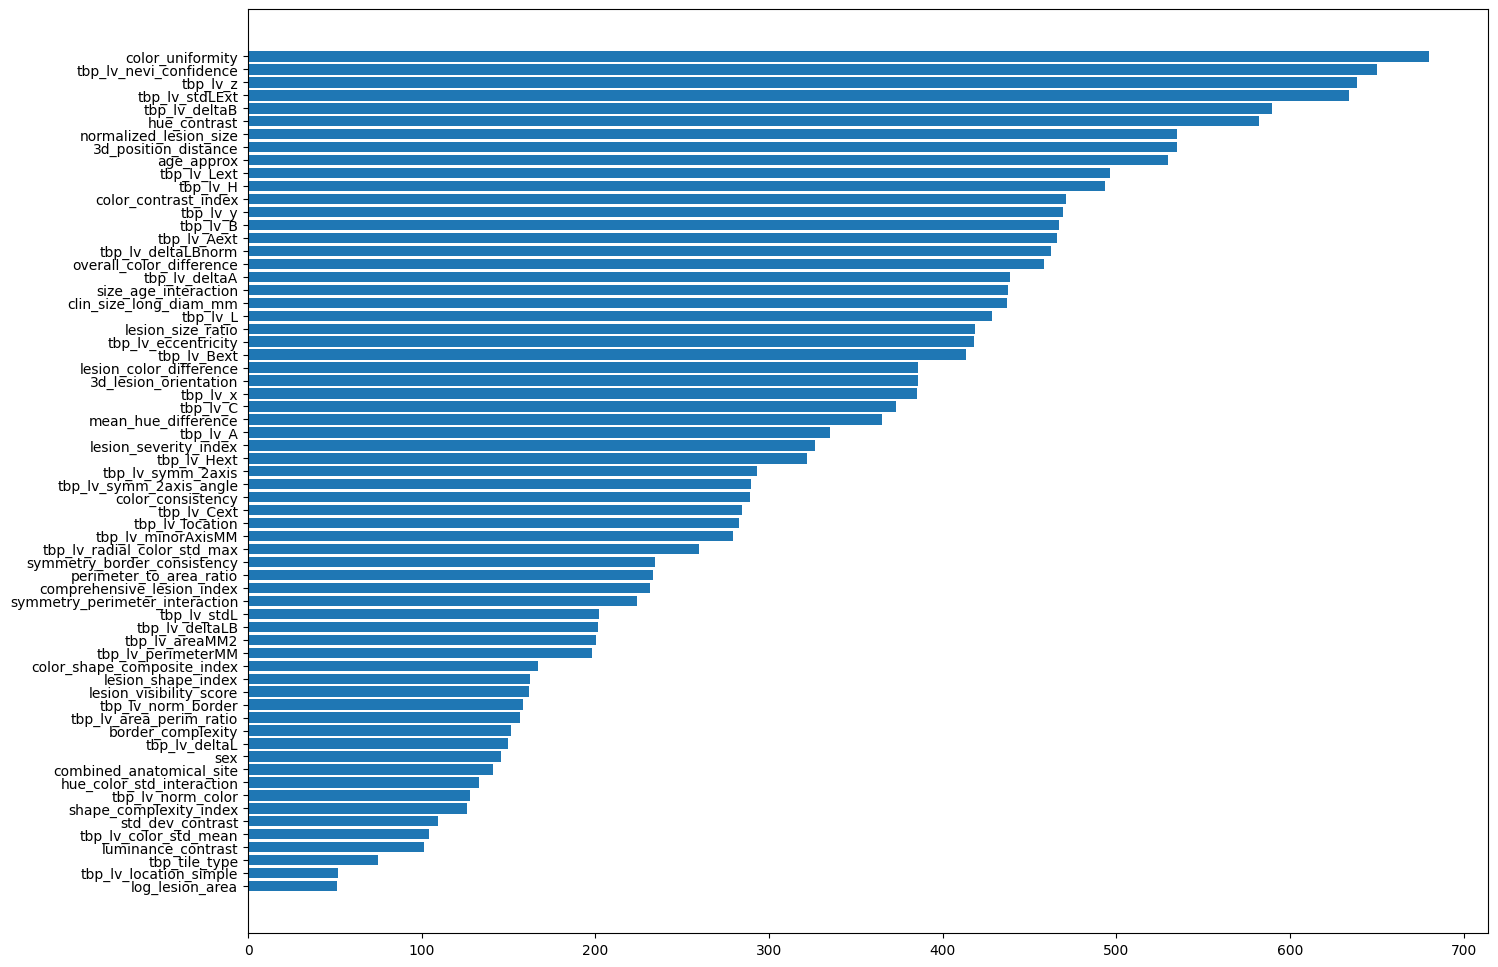

In [9]:
plt.figure(figsize=(16, 12))
plt.barh(df_imp["feature"], df_imp["importance"])
plt.show()

In [10]:
# How does the new feature(s) perform?
# I would go with the > 20 in the index.
df_imp[df_imp["feature"].isin(new_num_cols + new_cat_cols)].sort_values("importance", ascending=False)

,feature,importance
64,color_uniformity,680.0
59,hue_contrast,582.2
58,normalized_lesion_size,535.0
57,3d_position_distance,534.6
53,color_contrast_index,471.2
48,overall_color_difference,458.0
46,size_age_interaction,437.6
43,lesion_size_ratio,418.8
40,lesion_color_difference,386.0
39,3d_lesion_orientation,386.0


In [11]:
X_cat = category_encoder.fit_transform(df_test[cat_cols])
for c, cat_col in enumerate(cat_cols):
    df_test[cat_col] = X_cat[:, c]

In [12]:
preds = np.mean([model.predict(df_test[train_cols]) for model in models], 0)

In [13]:
df_sub = pd.read_csv(f"{base_path}/sample_submission.csv")
df_sub["target"] = preds
df_sub

,isic_id,target
0,ISIC_0015657,0.001719
1,ISIC_0015729,0.001216
2,ISIC_0015740,0.004205


In [14]:
df_sub.to_csv("submission.csv", index=False)